Устанавливаются необходимые библиотеки: для парсинга (requests, bs4, selenium), анализа данных (pandas, numpy), визуализации (matplotlib, seaborn, wordcloud).

Устанавливается chromedriver, нужный для автоматизации браузера через selenium.

In [17]:
!pip install requests beautifulsoup4 selenium pandas numpy matplotlib seaborn wordcloud
!apt-get update
!apt install -y chromium-chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 1s (198 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

класс BookSpider, который предназначен для веб-скрапинга данных о книгах с веб-сайта.
Он использует библиотеки Selenium и BeautifulSoup для автоматизации процесса извлечения информации о книгах, таких как название, цена, рейтинг и доступность.
Данные собираются с нескольких страниц и сохраняются в различных форматах (CSV, JSON, Excel)

requests: для выполнения HTTP-запросов (не используется в данном коде).

BeautifulSoup: для парсинга HTML-кода.

selenium: для автоматизации браузера и взаимодействия с динамическим контентом.

pandas: для работы с данными и их сохранения в различных форматах.

numpy: для генерации случайных задержек.

time: для управления временем выполнения.

re: для работы с регулярными выражениями.

WordCloud и Counter: для создания облаков слов (не используются в данном коде).

urljoin: для корректного формирования URL.

Конструктор __init__ принимает базовый URL, максимальное количество страниц для сканирования и параметр для работы в фоновом режиме (headless).

setup_selenium: настраивает параметры для работы с Selenium.

fetch_page: загружает страницу по указанному URL и добавляет случайную задержку для имитации человеческого поведения.

parse_page: парсит HTML-код страницы, извлекая информацию о книгах и проверяя наличие следующей страницы.

crawl: основной метод, который управляет процессом сканирования, переходя по страницам и собирая данные.

save_data: сохраняет собранные данные в указанный формат (CSV, JSON или Excel).
close: закрывает браузер после завершения работы.

options.add_argument('--headless'):
Эта опция запускает браузер в "безголовом" режиме, что означает, что интерфейс браузера не будет отображаться на экране.

options.add_argument('--no-sandbox'):
Эта опция отключает режим песочницы (sandbox) для браузера. Режим песочницы используется для повышения безопасности, изолируя процессы браузера от системы.

options.add_argument('--disable-dev-shm-usage'):
Эта опция отключает использование разделяемой памяти (shared memory) для браузера.

In [18]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from urllib.parse import urljoin

class BookSpider:
    def __init__(self, base_url, max_pages=3, headless=True):
        self.base_url = base_url
        self.max_pages = max_pages
        self.data = []
        self.setup_selenium(headless)
        self.visited_urls = set()

    def setup_selenium(self, headless):
        options = Options()
        if headless:
            options.add_argument('--headless')
        options.add_argument('--no-sandbox')
        options.add_argument('--disable-dev-shm-usage')
        self.driver = webdriver.Chrome(options=options)

    def fetch_page(self, url):
        try:
            if url in self.visited_urls:
                return None

            self.driver.get(url)
            time.sleep(np.random.uniform(1, 3))  # Случайная задержка
            self.visited_urls.add(url)
            return self.driver.page_source
        except Exception as e:
            print(f"Error fetching {url}: {e}")
            return None

    def parse_page(self, html):
        soup = BeautifulSoup(html, 'html.parser')
        books = soup.find_all('article', class_='product_pod')

        page_data = []
        for book in books:
            try:
                title = book.h3.a['title']
                price = float(book.find('p', class_='price_color').text[1:])  # Убираем символ £
                rating = book.p['class'][1]  # Например: 'Three' → 3
                rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
                availability = book.find('p', class_='instock').text.strip()

                page_data.append({
                    'title': title,
                    'price': price,
                    'rating': rating_map.get(rating, 0),
                    'availability': availability,
                    'timestamp': pd.Timestamp.now()
                })
            except Exception as e:
                print(f"Error parsing book: {e}")
                continue

        # Получаем ссылку на следующую страницу
        next_page = soup.find('li', class_='next')
        if next_page:
            next_url = urljoin(self.base_url, next_page.a['href'])
            return page_data, next_url
        return page_data, None

    def crawl(self):
        current_url = self.base_url
        page_count = 0

        while current_url and page_count < self.max_pages:
            print(f"Crawling {current_url}")
            html = self.fetch_page(current_url)
            if html:
                page_data, next_url = self.parse_page(html)
                self.data.extend(page_data)
                current_url = next_url
                page_count += 1

    def save_data(self, format='csv', filename='books_data'):
        df = pd.DataFrame(self.data)
        if format == 'csv':
            df.to_csv(f"{filename}.csv", index=False)
        elif format == 'json':
            df.to_json(f"{filename}.json", orient='records')
        elif format == 'excel':
            df.to_excel(f"{filename}.xlsx", index=False)
        print(f"Data saved to {filename}.{format}")
        return df

    def close(self):
        self.driver.quit()

In [19]:
# Инициализация и запуск паука
spider = BookSpider(
    base_url="https://books.toscrape.com",
    max_pages=5,  # Увеличим количество страниц для большего датасета
    headless=True
)

spider.crawl()
df = spider.save_data(format='csv', filename='books_data')
spider.close()

# Просмотр первых строк данных
df.head()

Crawling https://books.toscrape.com
Crawling https://books.toscrape.com/catalogue/page-2.html
Crawling https://books.toscrape.com/page-3.html
Data saved to books_data.csv


,title,price,rating,availability,timestamp
0,A Light in the Attic,51.77,3,In stock,2025-05-26 07:47:47.126044
1,Tipping the Velvet,53.74,1,In stock,2025-05-26 07:47:47.126229
2,Soumission,50.10,1,In stock,2025-05-26 07:47:47.126367
3,Sharp Objects,47.82,4,In stock,2025-05-26 07:47:47.126498
4,Sapiens: A Brief History of Humankind,54.23,5,In stock,2025-05-26 07:47:47.126636


count: Количество непустых значений в каждом столбце
В данном случае 40 непустых значений

mean: Среднее значение
Для числовых столбцов показывает среднее арифметическое
Для столбца с timestamp показывает средний момент времени

min: Минимальное значение в столбце

max: Максимальное значение в столбце

25%: Первый квартиль (25-й процентиль)

25% значений ниже этой отметки

50%: Медиана (второй квартиль)

50% значений ниже этой отметки

75%: Третий квартиль (75-й процентиль)

75% значений ниже этой отметки

std: Стандартное отклонение

Показывает разброс значений относительно среднего

In [20]:
# Основная статистика
print("Основная статистика:")
print(df.describe())

# Информация о типах данных
print("\nИнформация о данных:")
print(df.info())

# Проверка пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())

Основная статистика:
           price     rating                      timestamp
count  40.000000  40.000000                             40
mean   34.958750   3.050000  2025-05-26 07:47:48.406713856
min    12.840000   1.000000     2025-05-26 07:47:47.126044
25%    22.575000   2.000000  2025-05-26 07:47:47.127445248
50%    34.080000   3.000000  2025-05-26 07:47:48.406646016
75%    50.407500   4.250000  2025-05-26 07:47:49.686010624
max    57.250000   5.000000     2025-05-26 07:47:49.687336
std    14.111908   1.501282                            NaN

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         40 non-null     object        
 1   price         40 non-null     float64       
 2   rating        40 non-null     int64         
 3   availability  40 non-null     object        
 4   timestamp     40 no

<ipython-input-32-ef00048d20e6>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
<ipython-input-32-ef00048d20e6>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='price', y='title', data=top_expensive, palette='magma')


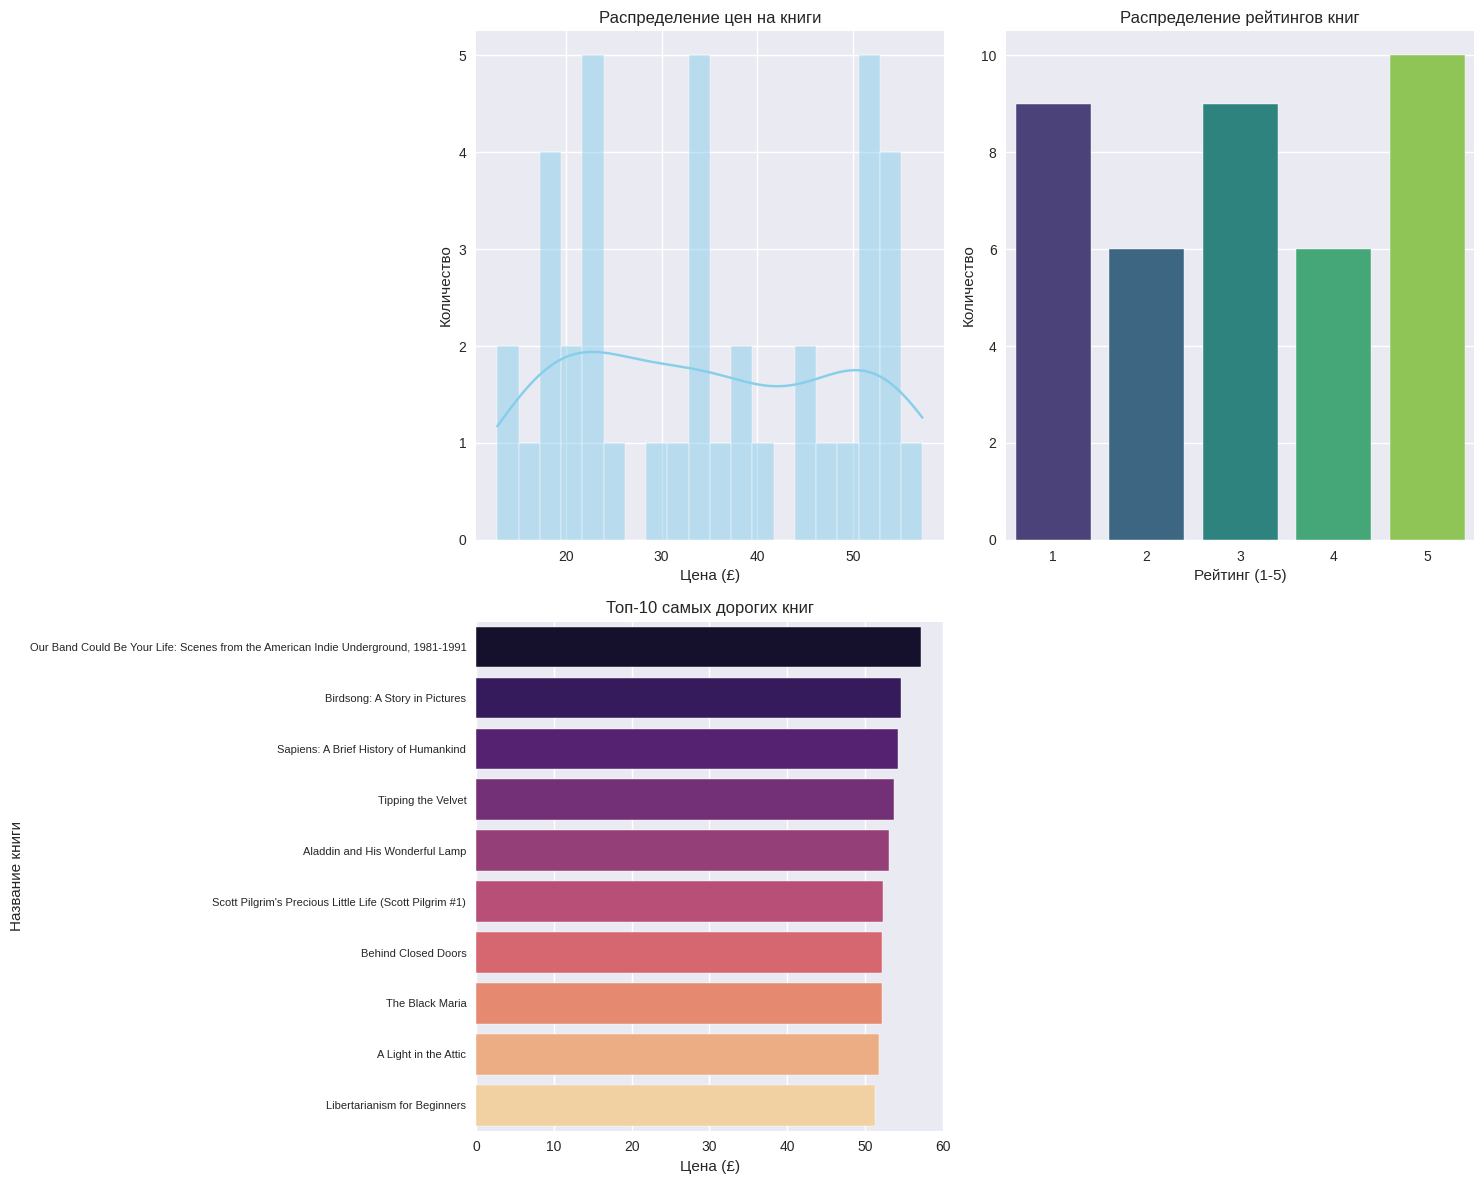

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Убедитесь, что Seaborn установлен

# Используйте доступный стиль
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(15, 12))

# 1. Распределение цен
plt.subplot(2, 2, 1)
sns.histplot(df['price'], bins=20, kde=True, color='skyblue')
plt.title('Распределение цен на книги', fontsize=12)
plt.xlabel('Цена (£)')
plt.ylabel('Количество')

# 2. Распределение рейтингов
plt.subplot(2, 2, 2)
rating_counts = df['rating'].value_counts().sort_index()
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')
plt.title('Распределение рейтингов книг', fontsize=12)
plt.xlabel('Рейтинг (1-5)')
plt.ylabel('Количество')

# 3. Топ-10 самых дорогих книг
plt.subplot(2, 2, 3)
top_expensive = df.sort_values('price', ascending=False).head(10)
sns.barplot(x='price', y='title', data=top_expensive, palette='magma')
plt.title('Топ-10 самых дорогих книг', fontsize=12)
plt.xlabel('Цена (£)')
plt.ylabel('Название книги')
plt.yticks(fontsize=8)


plt.tight_layout()
plt.show()

Регулярное выражение r'\w+' используется для поиска всех последовательностей "слов" в строке.

r'': Префикс r указывает на то, что строка является "сырой" (raw string). Это означает, что специальные символы, такие как обратные слэши (\), не будут экранированы. Это удобно при работе с регулярными выражениями, так как позволяет избежать путаницы с экранированием.

\w: Этот символ обозначает "буквенный символ" и включает в себя:
Все буквы латинского алфавита (как заглавные, так и строчные).
Цифры (0-9).
Символ подчеркивания (_).

Таким образом, \w соответствует любому "словесному" символу.


+: Этот квантификатор указывает, что предыдущий символ (в данном случае \w) должен встречаться один или более раз. То есть \w+ будет соответствовать любой последовательности из одного или более буквенных символов, цифр или символов подчеркивания.

выражение ищет все последовательности слов в строке text, преобразованной в нижний регистр.

В результате вы получаете список всех слов, игнорируя знаки препинания и пробелы.

<ipython-input-29-c931c31d7a3a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for word, count in common_words],


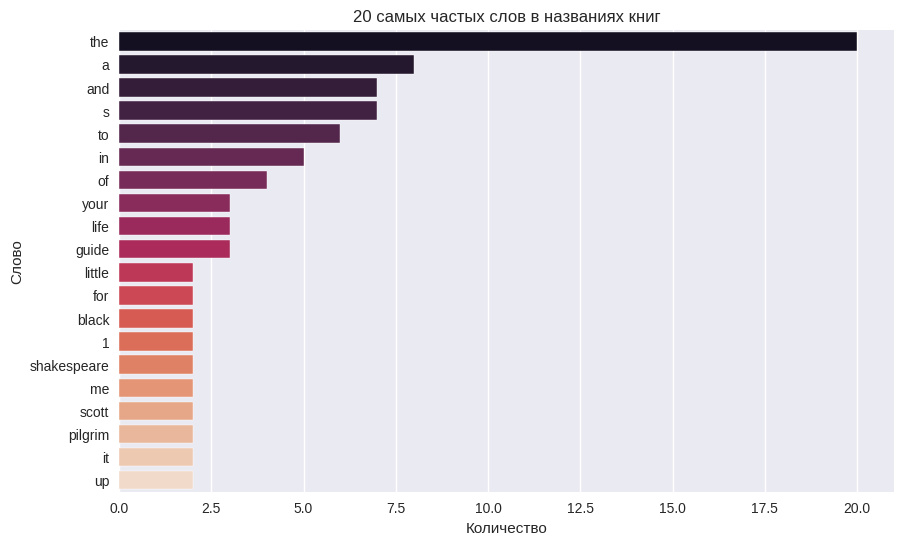

In [29]:
# Создаем текстовый корпус из названий книг
text = ' '.join(df['title'].values)


# Анализ наиболее частых слов
words = re.findall(r'\w+', text.lower())
word_counts = Counter(words)
common_words = word_counts.most_common(20)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x=[count for word, count in common_words],
            y=[word for word, count in common_words],
            palette='rocket')
plt.title('20 самых частых слов в названиях книг', fontsize=12)
plt.xlabel('Количество')
plt.ylabel('Слово')
plt.show()

<ipython-input-30-58eb229928d8>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.values, y=category_counts.index, palette='coolwarm')
<ipython-input-30-58eb229928d8>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price.values, y=avg_price.index, palette='summer')


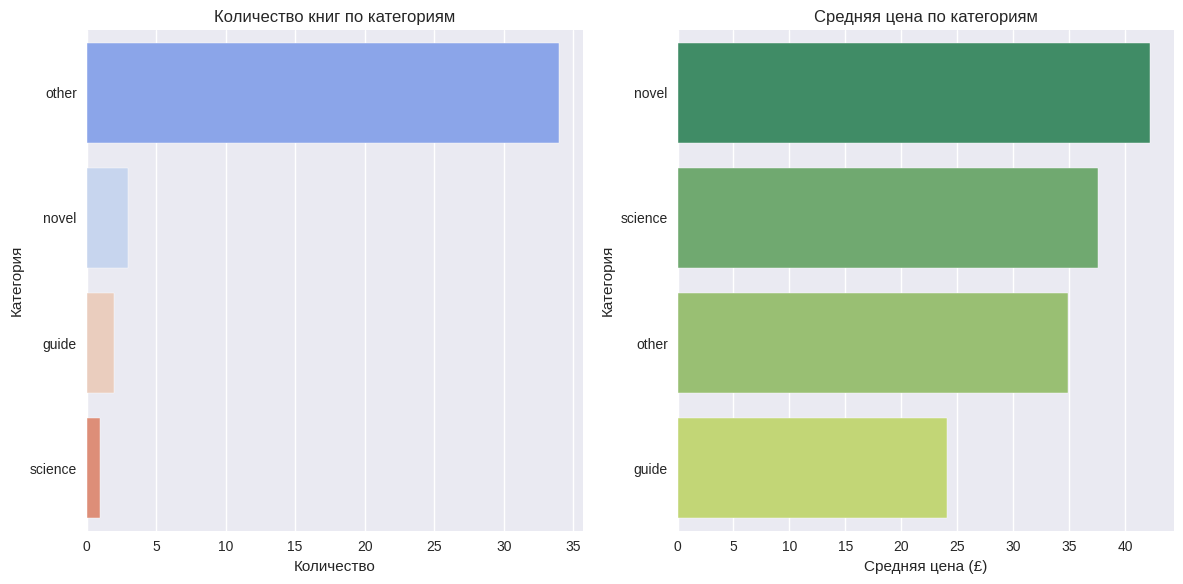

In [30]:
# Функция для извлечения категорий из названий
def extract_categories(title):
    common_categories = {
        'novel': ['novel', 'story', 'tale'],
        'guide': ['guide', 'handbook', 'manual'],
        'history': ['history', 'historical'],
        'science': ['science', 'scientific'],
        'children': ['children', 'kids', 'child']
    }

    title_lower = title.lower()
    for category, keywords in common_categories.items():
        if any(keyword in title_lower for keyword in keywords):
            return category
    return 'other'

# Добавляем категории в датафрейм
df['category'] = df['title'].apply(extract_categories)

# Анализ по категориям
plt.figure(figsize=(12, 6))

# 1. Количество книг по категориям
plt.subplot(1, 2, 1)
category_counts = df['category'].value_counts()
sns.barplot(x=category_counts.values, y=category_counts.index, palette='coolwarm')
plt.title('Количество книг по категориям', fontsize=12)
plt.xlabel('Количество')
plt.ylabel('Категория')

# 2. Средняя цена по категориям
plt.subplot(1, 2, 2)
avg_price = df.groupby('category')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price.values, y=avg_price.index, palette='summer')
plt.title('Средняя цена по категориям', fontsize=12)
plt.xlabel('Средняя цена (£)')
plt.ylabel('Категория')

plt.tight_layout()
plt.show()

In [31]:
# Создаем сводный отчет
report = {
    'total_books': len(df),
    'avg_price': round(df['price'].mean(), 2),
    'avg_rating': round(df['rating'].mean(), 2),
    'price_range': (round(df['price'].min(), 2), round(df['price'].max(), 2)),
    'most_common_category': df['category'].value_counts().idxmax(),
    'most_expensive_book': {
        'title': df.loc[df['price'].idxmax()]['title'],
        'price': round(df['price'].max(), 2)
    },
    'top_rated_books': df.sort_values('rating', ascending=False).head(3)[['title', 'rating']].to_dict('records')
}

# Сохраняем отчет в JSON
import json
with open('books_analysis_report.json', 'w') as f:
    json.dump(report, f, indent=2)

# Сохраняем обработанные данные
df.to_csv('processed_books_data.csv', index=False)

print("Анализ завершен! Результаты сохранены в файлы:")
print("- books_analysis_report.json")
print("- processed_books_data.csv")

Анализ завершен! Результаты сохранены в файлы:
- books_analysis_report.json
- processed_books_data.csv
